# Onslow et al. 2014

### A Canonical Circuit for Generating Phase-Amplitude Coupling

Replicating the Onslow model, consisting of a set of coupled E-I populations generating theta-nested gamma oscillations. The authors used the Wilson-Cowan formalism. Equations and parameters are given in the paper (Methods, _Description of the model_). 

In [1]:
sum2 = sum # backup for plotting later

from brian2 import *
# from tqdm import tqdm
from tqdm.notebook import tqdm

# Suppress code generation messages on the console
BrianLogger.suppress_name('resolution_conflict')
BrianLogger.suppress_hierarchy('brian2.codegen')


In [2]:
# Fixed parameters
seed_val = 42
seed(seed_val)

duration = 3*second
sim_dt = 0.1*ms
stim_dt = 1*ms

W_EE = 2.4
W_EI = 2.
W_IE = 2.
W_II = 0.

gain_E = 0.7
gain_I = 0.

tau_E = 3.2*ms
tau_I = 3.2*ms

sigma_E = 0.
sigma_I = 0.

xm = 1.
beta = 4.

# Kuramoto oscillators
N_K = 100
sync_K = 15
gain_K = 55
offset_K = 0. #+pi/2.
f0 = 4.
sigma_K = 0.5

# stimulation
S0 = 1
theta_deg = 75
theta = theta_deg*pi/180
tau_stim = 6*ms
t_stim_on = 1000*ms
t_stim_off = t_stim_on + 10*stim_dt

# stimulation
#stim_dt = defaultclock.dt
tv = linspace(0, int(duration/ms), int(duration/stim_dt+1))
stim_E_tv = S0*(tv>t_stim_on/ms) - S0*(tv>t_stim_off/ms)
stim_I_tv = S0*(tv>t_stim_on/ms) - S0*(tv>t_stim_off/ms)

stim_E = TimedArray(stim_E_tv, dt=stim_dt)
stim_I = TimedArray(stim_I_tv, dt=stim_dt)


# PRC calculations
N_sims = 32
delays = linspace(0, 1/f0, N_sims+1)*second

In [3]:
# Onslow equations
eqs_onslow = '''
    dE/dt = 1/tau_E * (-E + 1 / (1 + exp(-beta*(gain_E*theta_E + W_EE*E - W_IE*I + g_stim_E*stim_E(t-delay) - xm)))) + sigma_E*sqrt(2/tau_E)*xi_E : 1
    dI/dt = 1/tau_I * (-I + 1 / (1 + exp(-beta*(gain_I*theta_I + W_EI*E - W_II*I + g_stim_I*stim_I(t-delay) - xm)))) + sigma_I*sqrt(2/tau_I)*xi_I : 1
    
    theta_E : 1 (linked)
    theta_I : 1 (linked)
    
    g_stim_E : 1
    g_stim_I : 1
    
    delay : second
'''

# Kuramoto oscillators
eqs_kuramoto = '''
    dTheta/dt = ((omega + (kN * PIF) - gain*X*sin(Theta - pi/2 + offset)) * second**-1) : 1
    PIF = .5 * (sin(ThetaPreInput - Theta)) : 1
    ThetaPreInput : 1
    omega : 1 (constant)
    kN : 1 (shared)         # k/N ratio, affects sync.
    gain : 1 (shared)       # this is the input gain, affects the phase reset aggressiveness
    offset : 1 (shared)     # range [0, 2*pi], controls phase reset PRC
    X : 1 (linked)          # this is linked to the firing rates
'''

# synapses
syn_kuramoto_eqs = '''
    ThetaPreInput_post = Theta_pre
'''

# Order parameter group calculation equations
pop_avg_eqs = '''
    x : 1
    y : 1
    coherence = sqrt(x**2 + y**2) : 1
    phase = arctan(y/x) + int(x<0 and y>0)*pi - int(x<0 and y<0)*pi: 1
    rhythm = coherence * sin(phase) : 1
    rhythm_pos = coherence * (sin(phase)+1)/2 : 1
    rhythm_simple = rhythm : 1
    rhythm_abs = abs(rhythm) : 1
    rhythm_rect = rhythm_pos : 1
    rhythm_zero = 0*rhythm_rect : 1   # for debugging
'''

syn_avg_eqs = '''
    x_post = cos(Theta_pre)/N_incoming : 1 (summed)
    y_post = sin(Theta_pre)/N_incoming : 1 (summed)
'''

In [4]:
# Make coupled E-I group
G_pop = NeuronGroup(N=1, model=eqs_onslow, method='euler', name='Population')
G_pop.g_stim_E = 1.
G_pop.g_stim_I = 1.

G_kur = NeuronGroup(N=N_K,
                model=eqs_kuramoto,
                threshold='True',
                method='euler',
                name='Kuramoto_oscillators_N_%d' % N_K)

# Make Kuramoto oscillators group
theta0 = 2*pi*rand(N_K) # uniform U~[0,2π]
omega0 = 2*pi*(f0 + sigma_K*randn(N_K)) # ~N(2πf0,σ)
G_kur.Theta = theta0
G_kur.omega = omega0
G_kur.kN = sync_K
G_kur.gain = gain_K
G_kur.offset = offset_K

# Add synapses
syn_kur =  Synapses(G_kur, G_kur, on_pre=syn_kuramoto_eqs, method='euler', name='Kuramoto_intra')
syn_kur.connect(condition='i!=j')

# Kuramoto order parameter group
G_pop_avg = NeuronGroup(1,
                model=pop_avg_eqs,
                #method='euler',
                name='Kuramoto_averaging')
r0 = 1/N_K * sum(exp(1j*G_kur.Theta))
G_pop_avg.x = real(r0)  # avoid division by zero
G_pop_avg.y = imag(r0)
syn_avg = Synapses(G_kur, G_pop_avg, syn_avg_eqs, name='Kuramoto_avg')
syn_avg.connect()


# Link inputs / outputs
G_kur.X = linked_var(G_pop, 'E')
G_pop.theta_E = linked_var(G_pop_avg, 'rhythm_rect') # theta input to E
G_pop.theta_I = linked_var(G_pop_avg, 'rhythm_zero') # no input to I

In [5]:
# Add state monitors
mon = StateMonitor(G_pop, ['E', 'I'], record=True)
mon_kur = StateMonitor(G_kur, ['Theta'], record=True)
mon_order_param = StateMonitor(G_pop_avg, ['coherence', 'phase', 'rhythm', 'rhythm_rect'], record=True)

defaultclock.dt = sim_dt

# Snapshot network state (backup)
store()

In [6]:
# Run a simulation without any stimulation and save the phase
G_pop.g_stim_E = 0.
G_pop.g_stim_I = 0.
G_pop.delay = 1*second

run(duration)

phase_def = mon_order_param.phase[0]

In [7]:
# Run a simulation with stimulation
restore()

G_pop.g_stim_E = 1.
G_pop.g_stim_I = 0.
G_pop.delay = 0*second

run(duration)

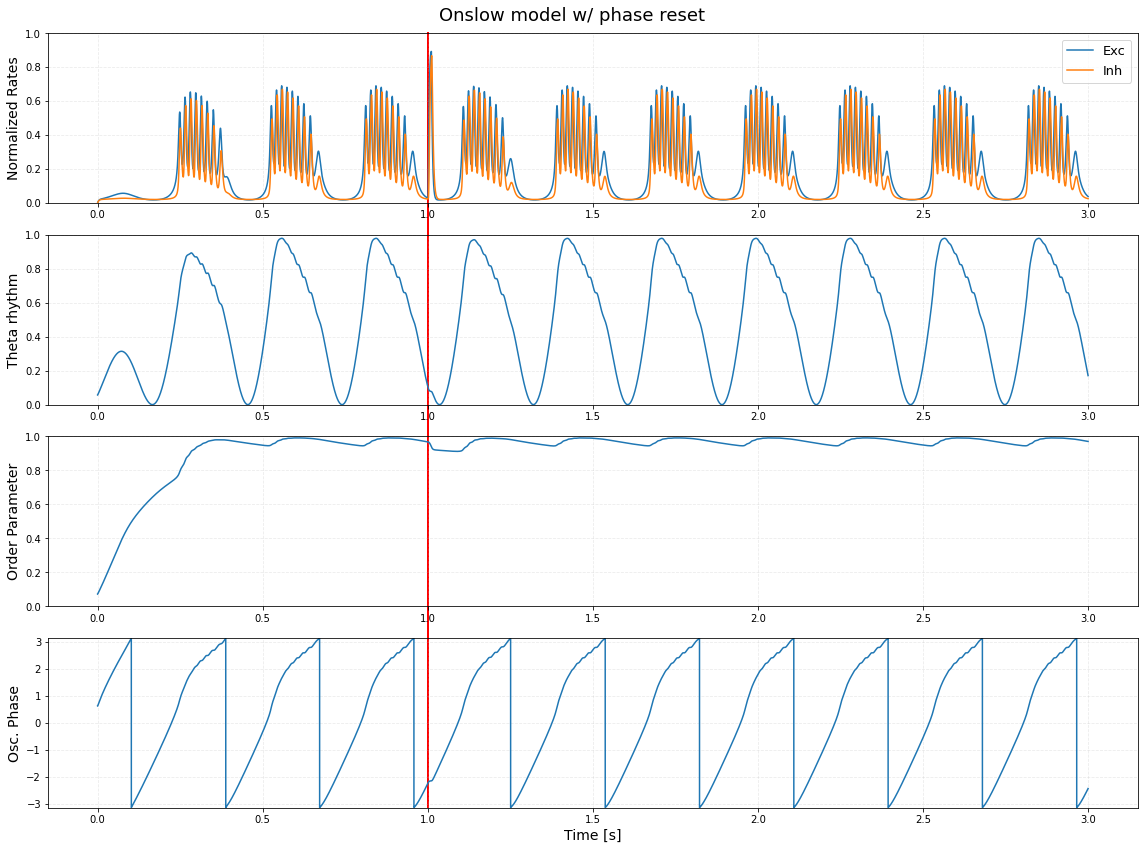

In [8]:
# Plot the results
fig, axs = subplots(4,1)
fig.set_figheight(12)
fig.set_figwidth(16)
axs[0].plot(mon.t/second, mon.E[0], color='C0', label='Exc')
axs[0].plot(mon.t/second, mon.I[0], color='C1', label='Inh')
axs[1].plot(mon_order_param.t/second, mon_order_param.rhythm_rect[0], color='C0', label='Theta rhythm')
axs[2].plot(mon_order_param.t/second, mon_order_param.coherence[0], color='C0', label='Order Parameter')
axs[3].plot(mon_order_param.t/second, mon_order_param.phase[0], color='C0', label='Ensemble Phase')

axs[0].axvline(x=t_stim_on/second, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=False)
axs[1].axvline(x=t_stim_on/second, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=False)
axs[2].axvline(x=t_stim_on/second, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=False)
axs[3].axvline(x=t_stim_on/second, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=True)

axs[0].grid(ls='dashed', alpha=0.25)
axs[1].grid(ls='dashed', alpha=0.25)
axs[2].grid(ls='dashed', alpha=0.25)
axs[3].grid(ls='dashed', alpha=0.25)

axs[0].set_ylabel('Normalized Rates', fontsize=14)
axs[1].set_ylabel('Theta rhythm', fontsize=14)
axs[2].set_ylabel('Order Parameter', fontsize=14)
axs[3].set_ylabel('Osc. Phase', fontsize=14)

axs[0].set_ylim([0,1])
axs[1].set_ylim([0,1])
axs[2].set_ylim([0,1])
axs[3].set_ylim([-3.15,3.15])

axs[3].set_xlabel('Time [s]', fontsize=14)

axs[0].legend(loc='best', fontsize=13)

#fig.text(0.04, 0.5, 'Normalized Firing Rates', va='center', rotation='vertical', fontdict={'size' : 12})
#lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
#lines, labels = [sum2(lol, []) for lol in zip(*lines_labels)]
#fig.legend(lines, labels, loc=[0.9, 0.86])

fig.suptitle('Onslow model w/ phase reset', fontsize=18)

tight_layout()

fig.savefig('Phase_Reset_Onslow.png', facecolor='white', transparent=False)
fig.savefig('Phase_Reset_Onslow.pdf', dpi=300, facecolor='white', transparent=False)
show()

### Calculate the PRC

We will restore the network state and run the model multiple times to get the PRC.

In [9]:
PRC_all = []
phase_vals_all = []
delay_extra = 25 # samples
# stim_range = array([0.8, 0.9, 1., 1.2.])
stim_range = arange(0.8,1.5,.1)

# Run the simulations
for stim_gain in tqdm(stim_range):
    PRC = []
    phase_vals = []
    for sim in tqdm(range(0, len(delays))):        
        # Restore network state (stim on)
        restore()
        
        # Set stimulation gains again
        G_pop.g_stim_E = stim_gain
        G_pop.g_stim_I = stim_gain

        # Set the stimulation delay
        curr_delay = delays[sim]
        G_pop.delay = curr_delay

        # Run simulation for the specified duration
        run(duration, report=None)

        # get phase from order_param_mon
        phase = mon_order_param.phase[0]

        # find index of phase reset (based on stimulation onset)
        stim_onset = t_stim_on + curr_delay
        idx = int(stim_onset/sim_dt)

        # calculate d_phi
        d_phi = (phase[idx+delay_extra] - phase_def[idx+delay_extra])
        d_phi = (d_phi + np.pi) % (2*np.pi) - np.pi     # wrap between [-pi pi]


        PRC.append(d_phi)
        phase_vals.append(phase[idx])
    
    # Sort w.r.t stim. phase values
    idxs = np.argsort(phase_vals)

    # Sort the data points
    phase_vals = [phase_vals[i] for i in idxs]
    PRC = [PRC[i] for i in idxs]
    
    PRC_all.append(PRC)
    phase_vals_all.append(phase_vals)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

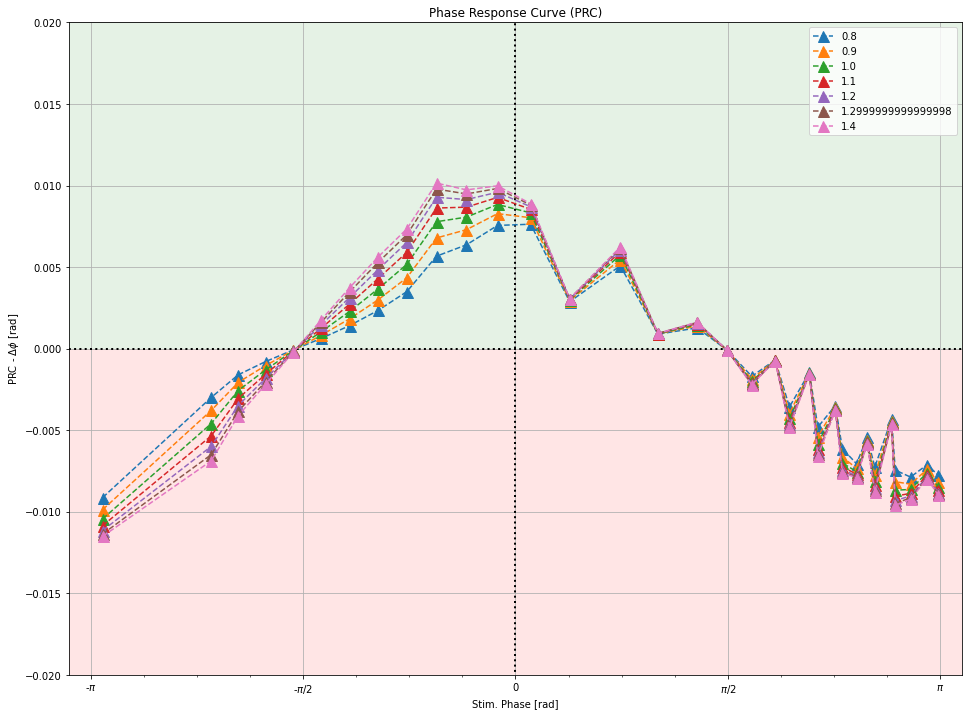

In [10]:
# Plot the PRC values
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
fig.set_figheight(12)
fig.set_figwidth(16)

for ii in range(0, len(PRC_all)):
    axs.plot(phase_vals_all[ii], PRC_all[ii], ls='--', marker='^', markersize=11, label=r'{0}'.format(stim_range[ii]), zorder=10+ii)

# Horizontal line @ y=0
axs.hlines(y=0., xmin=-2*np.pi, xmax=2*np.pi, linestyle=':', colors='k', linewidth=2., zorder=2)

# Vertical line @ x=0
axs.vlines(x=0., ymin=-4., ymax=4., linestyle=':', colors='k', linewidth=2., zorder=2)

# Fill positive (y>0) and negative (y<0)
axs.fill_between(x=[-4,4], y1=[4., 4.], color='green', alpha=0.1)
axs.fill_between(x=[-4,4], y1=[-4., -4.], color='red', alpha=0.1)

# Add text
boxp = dict(boxstyle='square', alpha=0.75, facecolor='white', edgecolor='none')
#axs.text(x=-3.3, y=0.28, color='black', s='ADV', fontsize=11, verticalalignment='top', horizontalalignment='left', bbox=boxp, zorder=20)
#axs.text(x=-3.3, y=-0.28, color='black', s='DEL', bbox=boxp, zorder=21)

# Ticks
def format_func(x, pos):
    # find number of multiples of pi/2
    N = int(np.round(2 * x / np.pi))
    if N == -2:
        return r"-$\pi$"
    elif N == -1:
        return r"-$\pi/2$"
    elif N == 0:
        return "0"
    elif N == 1:
        return r"$\pi/2$"
    elif N == 2:
        return r"$\pi$"
    elif N % 2 > 0:
        return r"${0}\pi/2$".format(N)
    else:
        return r"${0}\pi$".format(N // 2)

axs.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
axs.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 8))
axs.xaxis.set_major_formatter(plt.FuncFormatter(format_func))

# Labels
axs.set_xlabel('Stim. Phase [rad]')
axs.set_ylabel(r'PRC - $\Delta\phi$ [rad]')

# Title
axs.set_title("Phase Response Curve (PRC)")

# Grids
axs.grid()

# Legend
axs.legend()

# Limits
axs.set_xlim([-3.3, 3.3])
axs.set_ylim([-0.02, 0.02])

fig.savefig('PRC_Onslow.png', facecolor='white', transparent=False)
fig.savefig('PRC_Onslow.pdf', dpi=300, facecolor='white', transparent=False)
show()


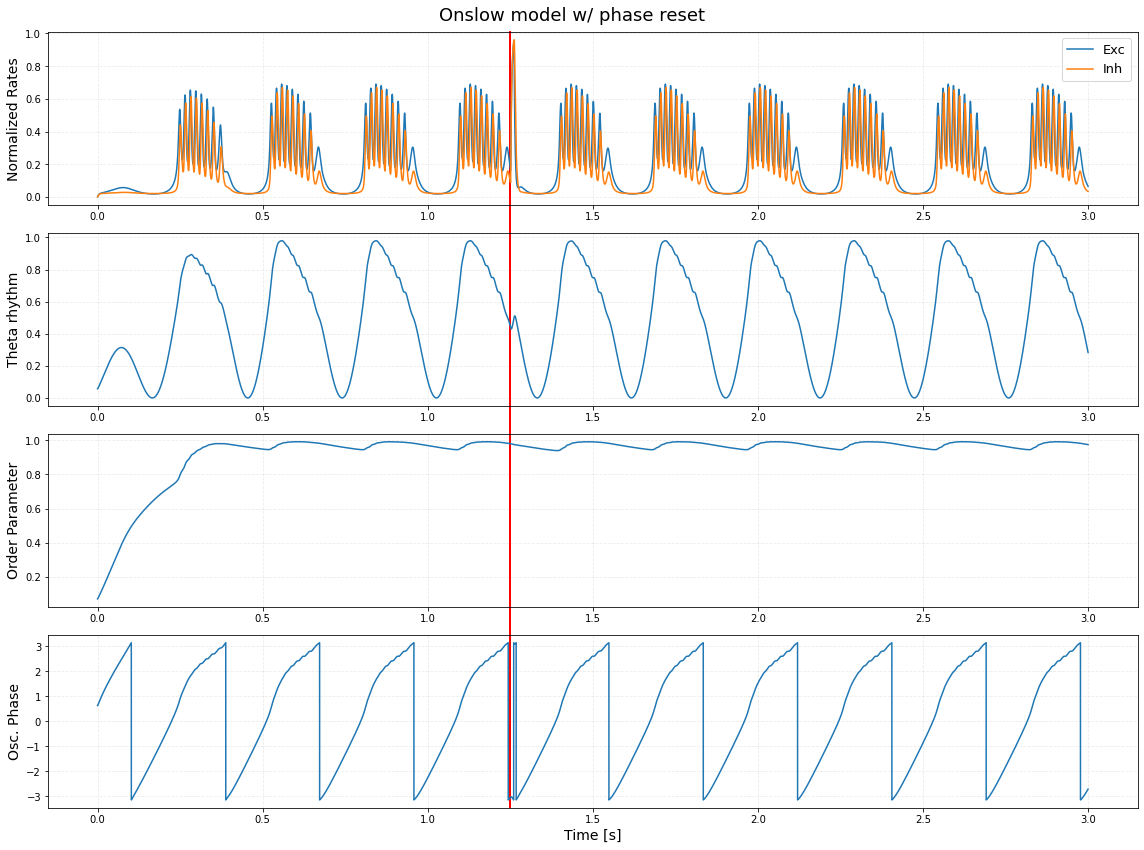

In [11]:
# Plot the results
fig, axs = subplots(4,1)
fig.set_figheight(12)
fig.set_figwidth(16)
axs[0].plot(mon.t/second, mon.E[0], color='C0', label='Exc')
axs[0].plot(mon.t/second, mon.I[0], color='C1', label='Inh')
axs[1].plot(mon_order_param.t/second, mon_order_param.rhythm_rect[0], color='C0', label='Theta rhythm')
axs[2].plot(mon_order_param.t/second, mon_order_param.coherence[0], color='C0', label='Order Parameter')
axs[3].plot(mon_order_param.t/second, mon_order_param.phase[0], color='C0', label='Ensemble Phase')

axs[0].axvline(x=stim_onset/second, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=False)
axs[1].axvline(x=stim_onset/second, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=False)
axs[2].axvline(x=stim_onset/second, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=False)
axs[3].axvline(x=stim_onset/second, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=True)

axs[0].grid(ls='dashed', alpha=0.25)
axs[1].grid(ls='dashed', alpha=0.25)
axs[2].grid(ls='dashed', alpha=0.25)
axs[3].grid(ls='dashed', alpha=0.25)

axs[0].set_ylabel('Normalized Rates', fontsize=14)
axs[1].set_ylabel('Theta rhythm', fontsize=14)
axs[2].set_ylabel('Order Parameter', fontsize=14)
axs[3].set_ylabel('Osc. Phase', fontsize=14)

axs[3].set_xlabel('Time [s]', fontsize=14)

axs[0].legend(loc='best', fontsize=13)

#fig.text(0.04, 0.5, 'Normalized Firing Rates', va='center', rotation='vertical', fontdict={'size' : 12})
#lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
#lines, labels = [sum2(lol, []) for lol in zip(*lines_labels)]
#fig.legend(lines, labels, loc=[0.9, 0.86])

fig.suptitle('Onslow model w/ phase reset', fontsize=18)

tight_layout()

show()